In [7]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob


In [22]:
from core.phantom import Phantom
from core.transducer_set import TransducerSet

In [24]:
from core import transducer_set

In [20]:
fantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3), # size of each voxel
            matrix_dims = (400,400,400), # number of voxels along each axis
            baseline = (1500, 1000), # background medium speed of sound and density
            seed = 5678,)


TypeError: assign_pose() missing 1 required positional argument: 'transform'

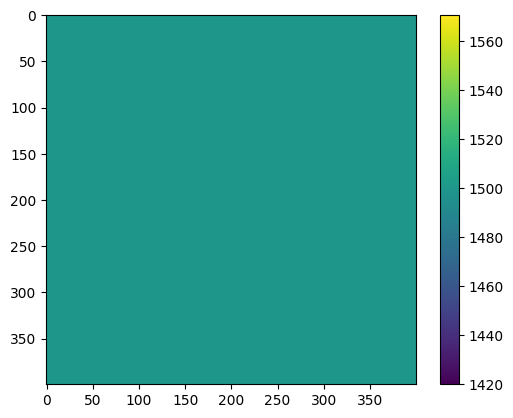

In [25]:

fantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3), # size of each voxel
            matrix_dims = (400,400,400), # number of voxels along each axis
            baseline = (1500, 1000), # background medium speed of sound and density
            seed = 5678,)

kidney_sos = 1560
kidney_rho = 1066
kidney_sigma = 27
kidney_noise_scale = 0.001
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=1)
kidney = tissue.Tissue(name='kidney', c=kidney_sos, rho=kidney_rho, sigma=kidney_sigma, 
                scale=kidney_noise_scale, label=2) 

pos = 0.7

fantom.add_tissue_sphere((pos,-pos,0), 8, fat) # sphere center, radius, tissue makeup
fantom.add_tissue_sphere((-pos,pos,0), 8, kidney)

plt.imshow(fantom.get_complete()[0,:,fantom.matrix_dims[2]//4, :], 
           vmin=np.amin(fantom.get_complete()[0]), vmax=np.amax(fantom.get_complete()[0]))
plt.colorbar()

n_transducers = 1 # number of transducers in trajectory

transducers = [transducer.Planewave(max_frequency = 2000000, # [Hz],
                         elements = 32,
                         element_width = 1e-4, # [m]
                         elevation = 1e-4 * 32, 
                         sweep = np.pi/3, # angles from -60 to 60 
                         ray_num = 64, # number of steering angles in the range prescribed by sweep 
                         focus_elevation = 0.02,# wherever you'd like to put the elevation focus
                         )
                for i in range(n_transducers)]

for t in transducers:
    t.make_sensor_coords(fantom.baseline[0])

transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

# global coordinate system origin (0,0,0) at centroid of phantom as defined above
for i in range(n_transducers):
    transducer_transform = geometry.Transform(translation=(0,0,0), rotation=(0,0,0)) # global coords of transducer centroid, zyx intrinsic tait-bryan
    transducer_set.assign_pose(i, transducer_transform)

transducer_set.plot_transducer_fovs(scale=0.05)
transducer_set.plot_transducers()

sensor = sensor.Sensor(transducer_set=transducer_set)

simprops = simulation.SimProperties(grid_size   = (1024,128,128), # you may need to tweak the grid size for maximum efficency
                 PML_size    = (32,8,8),
                 PML_alpha   = 2,
                 t_end       = 12e-5,           # [s]
                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                 alpha_coeff = 0.5, 	        # [dB/(MHz^y cm)]
                 alpha_power = 1.5,
                 )

In [ ]:
test_experiment = Experiment(
                 simulation_path = '', # your desired path
                 sim_properties  = simprops,
                 phantom         = phantom,
                 transducer_set  = transducer_set,
                 sensor          = sensor,
                 nodes           = 2, # how many compute nodes you plan to use
                 results         = None,
                 indices         = None,
                 workers         = 3, # how many workers/node
                 )

test_experiment.save()

test_experiment.run(dry=True)

#test_experiment.add_results()

#reconstruction = Compounding(test_experiment) # beta, may not currently work as intended


